In [1]:
from roboflow import Roboflow
from torch.utils.data import Dataset
import os
from PIL import Image
from transformers import SegformerFeatureExtractor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import SegformerForSemanticSegmentation
from evaluate import load
import torch
from torch import nn
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [2]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""
    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            lines = fid.readlines()
            data = [line.strip().split(',') for line in lines[1:]]
            self.id2label = {str(id_): name for id_, name in data}
        
        image_file_names = [f for f in os.listdir(self.root_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
        mask_file_names = [f for f in os.listdir(self.root_dir) if f.lower().endswith('.png')]
        image_bases = {f.replace('.jpg', '').replace('.jpeg', '') for f in image_file_names}
        mask_bases = {f.replace('_mask.png', '').replace('.png', '') for f in mask_file_names}
        common_bases = sorted(image_bases & mask_bases)
        self.images = [f"{base}.jpg" for base in common_bases]
        self.masks = [f"{base}_mask.png" for base in common_bases]
        
        print(f"Images: {len(self.images)}, Masks: {len(self.masks)}")
        print(f"First 5 images: {self.images[:5]}")
        print(f"First 5 masks: {self.masks[:5]}")
        print(f"id2label: {self.id2label}")
        if not self.images or not self.masks:
            raise ValueError(f"Нет парного соответствия изображений и масок в {self.root_dir}")
        if len(self.images) != len(self.masks):
            raise ValueError("Количество изображений и масок не совпадает!")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")
        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        print(f"Raw mask unique values for {self.masks[idx]}:", torch.unique(encoded_inputs['labels']).tolist())
        encoded_inputs['labels'] = (encoded_inputs['labels'] > 0).long()  # 0/1/255 -> 0/1
        print(f"Normalized mask unique values:", torch.unique(encoded_inputs['labels']).tolist())
        return encoded_inputs

In [3]:
class SegformerFinetuner(pl.LightningModule):
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.num_classes = len(id2label.keys())
        self.label2id = {v: k for k, v in self.id2label.items()}
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        self.train_mean_iou = load("mean_iou")
        self.val_mean_iou = load("mean_iou")
        self.test_mean_iou = load("mean_iou")
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, images, masks=None):
        images = images.to(self.device)
        if masks is not None:
            masks = masks.to(self.device)
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def test_step(self, batch, batch_nb):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        self.test_step_outputs.append({'test_loss': loss})

    def on_test_epoch_end(self):
        metrics = self.test_mean_iou.compute(
            num_labels=self.num_classes,
            ignore_index=255,
            reduce_labels=False,
        )
        avg_test_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]
        metrics = {"test_loss": avg_test_loss, "test_mean_iou": test_mean_iou, "test_mean_accuracy": test_mean_accuracy}
        for k, v in metrics.items():
            self.log(k, v)
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl

In [4]:
# rf = Roboflow(api_key="q3YSMGxcnMRqHCb9ppWg")
# project = rf.workspace("uit-kbay3").project("screen-segmentation")
# version = project.version(3)
# dataset = version.download("png-mask-semantic")

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/test/", feature_extractor)
test_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/test/", feature_extractor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)

checkpoint_path = "lightning_logs/version_35/checkpoints/epoch=14-step=765.ckpt"
segformer_finetuner = SegformerFinetuner.load_from_checkpoint(
    checkpoint_path,
    id2label=train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)
segformer_finetuner.to("cuda")  # Переносим на GPU

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    precision=16
)

The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'


Images: 807, Masks: 807
First 5 images: ['Laptop_monitor_101_jpg.rf.19721e33948dbd5fa570a63658f1ec0c.jpg', 'Laptop_monitor_102_jpg.rf.ec63710fdcd3301021726aa5e6e25b97.jpg', 'Laptop_monitor_103_jpg.rf.03296541421f9dcffac86f4601e6a6f7.jpg', 'Laptop_monitor_105_jpg.rf.6445e2308de04921f4d61db415b4f1c5.jpg', 'Laptop_monitor_108_jpg.rf.8dd25341e8e3b48fba8158ae5b5d9c1c.jpg']
First 5 masks: ['Laptop_monitor_101_jpg.rf.19721e33948dbd5fa570a63658f1ec0c_mask.png', 'Laptop_monitor_102_jpg.rf.ec63710fdcd3301021726aa5e6e25b97_mask.png', 'Laptop_monitor_103_jpg.rf.03296541421f9dcffac86f4601e6a6f7_mask.png', 'Laptop_monitor_105_jpg.rf.6445e2308de04921f4d61db415b4f1c5_mask.png', 'Laptop_monitor_108_jpg.rf.8dd25341e8e3b48fba8158ae5b5d9c1c_mask.png']
id2label: {'0': ' background', '1': ' screen'}
Images: 84, Masks: 84
First 5 images: ['Laptop_monitor_106_jpg.rf.93fc598ca459292f06e58b34aad905c4.jpg', 'Laptop_monitor_111_jpg.rf.4b9d57ceba0a69109f1ac017ac8f1dde.jpg', 'Laptop_monitor_134_jpg.rf.5f01be6d7d8ce

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpo

In [5]:
print("Test dataset size:", len(test_dataset))
print("Test images:", test_dataset.images[:5])
print("Train images:", train_dataset.images[:5])

Test dataset size: 84
Test images: ['Laptop_monitor_106_jpg.rf.93fc598ca459292f06e58b34aad905c4.jpg', 'Laptop_monitor_111_jpg.rf.4b9d57ceba0a69109f1ac017ac8f1dde.jpg', 'Laptop_monitor_134_jpg.rf.5f01be6d7d8ce9f4bccc3101d3f73dc7.jpg', 'Laptop_monitor_175_jpg.rf.7127e0e03c3eb90ae2d90ab723b0f24f.jpg', 'Laptop_monitor_205_jpg.rf.b8ac566faa60470dc7928f333c96be74.jpg']
Train images: ['Laptop_monitor_101_jpg.rf.19721e33948dbd5fa570a63658f1ec0c.jpg', 'Laptop_monitor_102_jpg.rf.ec63710fdcd3301021726aa5e6e25b97.jpg', 'Laptop_monitor_103_jpg.rf.03296541421f9dcffac86f4601e6a6f7.jpg', 'Laptop_monitor_105_jpg.rf.6445e2308de04921f4d61db415b4f1c5.jpg', 'Laptop_monitor_108_jpg.rf.8dd25341e8e3b48fba8158ae5b5d9c1c.jpg']


In [6]:
trainer.test(segformer_finetuner)
res = {
    "test_loss": trainer.callback_metrics["test_loss"].item(),
    "test_mean_iou": trainer.callback_metrics["test_mean_iou"].item(),
    "test_mean_accuracy": trainer.callback_metrics["test_mean_accuracy"].item()
}
print("Test results:", res)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Raw mask unique values for Laptop_monitor_106_jpg.rf.93fc598ca459292f06e58b34aad905c4_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_111_jpg.rf.4b9d57ceba0a69109f1ac017ac8f1dde_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_134_jpg.rf.5f01be6d7d8ce9f4bccc3101d3f73dc7_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_175_jpg.rf.7127e0e03c3eb90ae2d90ab723b0f24f_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_205_jpg.rf.b8ac566faa60470dc7928f333c96be74_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_213_jpg.rf.10f21a12e2422d9b6be9152ad5742a89_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_229_jpg.rf.3917c6bf1593b20dcec0c26d88992ba3_mask.png: [0, 255]
Normalized mask unique values: [0, 1]

Downcasting array dtype int64 to int32 to be compatible with 'Pillow'


Raw mask unique values for Smartphone_34_jpg.rf.95ca40ac48a7a37740a89d4feacd8465_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_419_jpg.rf.9987d3d823fa510510b8f79a66c798fb_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_425_jpg.rf.3142b28f2684ccab1361ceba288eb385_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_443_jpg.rf.9b7919a1c1daf92044f2ca2e05158d6f_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_457_jpg.rf.03cb6866384f12c92c667050fa4b4333_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_458_jpg.rf.3039bd33d5a095b7792537553b4eb0c1_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Smartphone_459_jpg.rf.088a019218e184e6c688610ee69b1ff5_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for S

Raw mask unique values for Laptop_monitor_106_jpg.rf.93fc598ca459292f06e58b34aad905c4_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_111_jpg.rf.4b9d57ceba0a69109f1ac017ac8f1dde_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_134_jpg.rf.5f01be6d7d8ce9f4bccc3101d3f73dc7_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_175_jpg.rf.7127e0e03c3eb90ae2d90ab723b0f24f_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_205_jpg.rf.b8ac566faa60470dc7928f333c96be74_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_213_jpg.rf.10f21a12e2422d9b6be9152ad5742a89_mask.png: [0, 255]
Normalized mask unique values: [0, 1]
Raw mask unique values for Laptop_monitor_229_jpg.rf.3917c6bf1593b20dcec0c26d88992ba3_mask.png: [0, 255]
Normalized mask unique values: [0, 1]

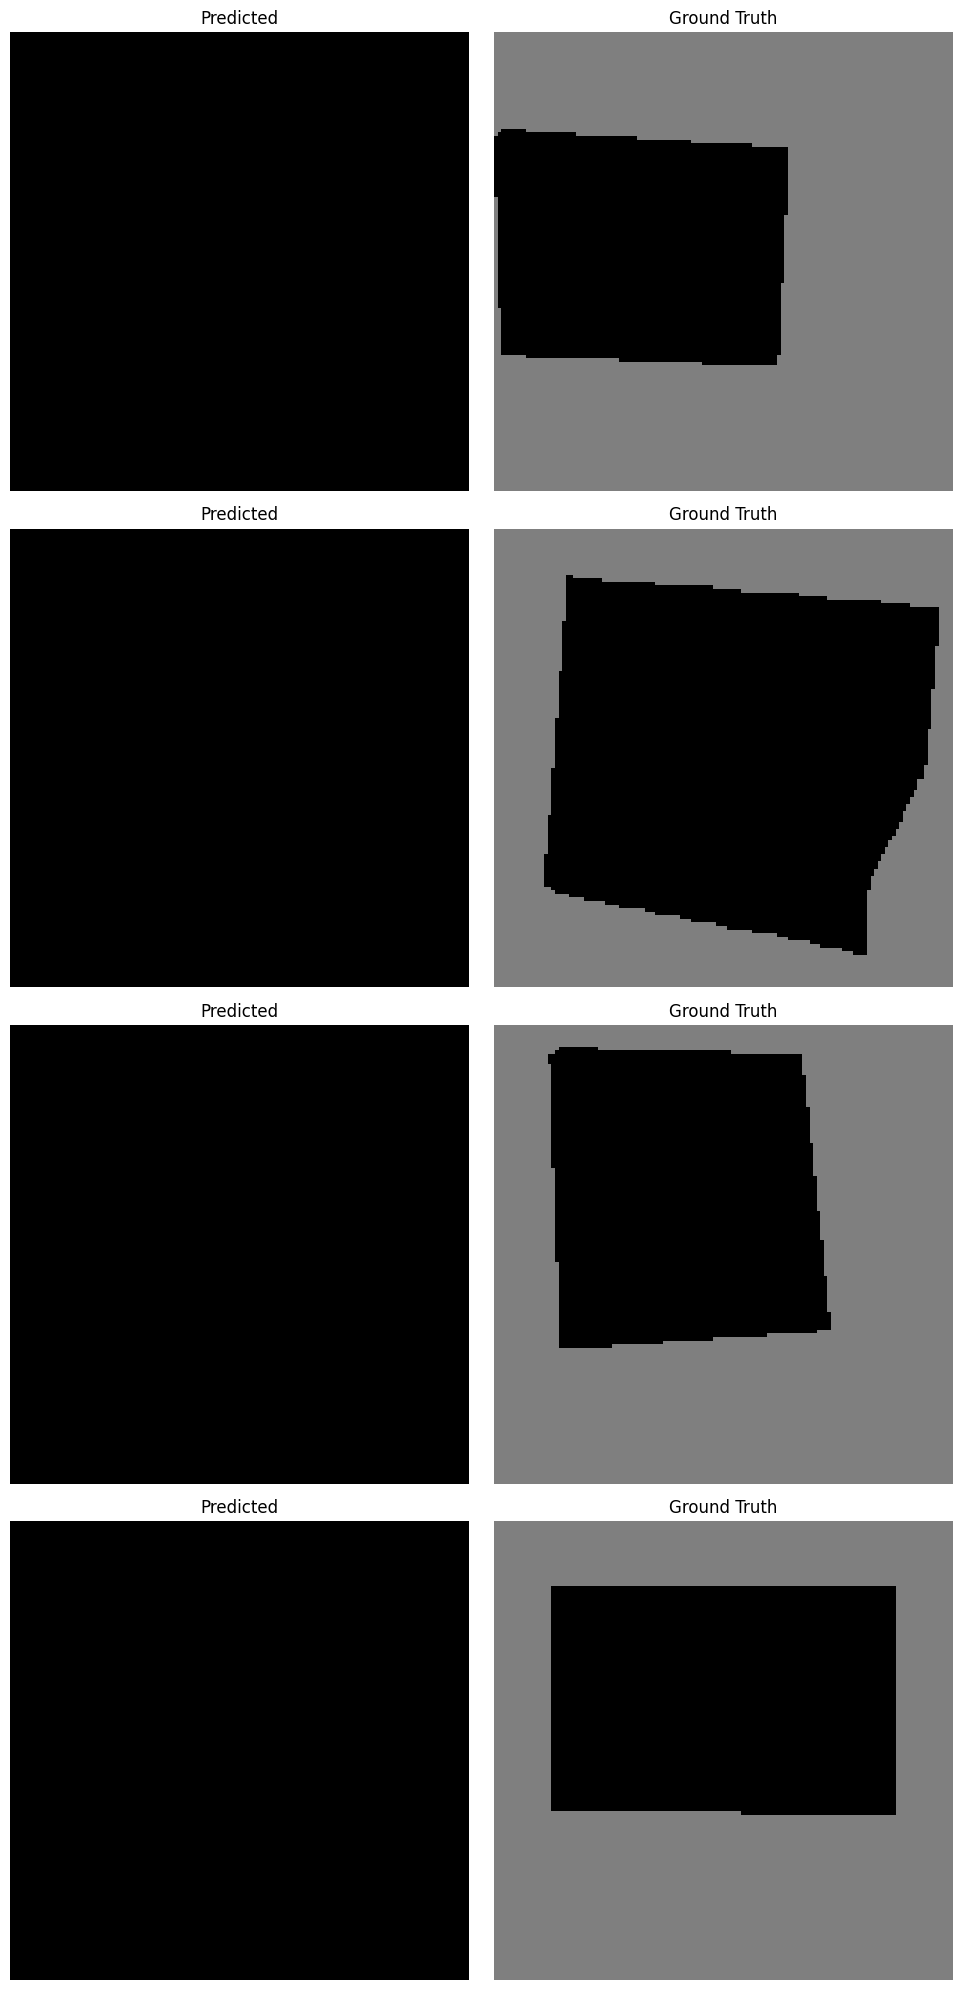

In [7]:
from matplotlib import pyplot as plt

# Функция визуализации из урока
color_map = {
    0: (0, 0, 0),    # background - черный
    1: (127, 127, 127),  # screen - серый
    # 255: (255, 255, 255)
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i, c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

# Визуализация предсказаний
segformer_finetuner.eval()
segformer_finetuner.to("cuda")
with torch.no_grad():
    for batch in test_dataloader:
        images, masks = batch['pixel_values'], batch['labels']
        images = images.to("cuda")
        masks = masks.to("cuda")
        outputs = segformer_finetuner.model(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        print("Predicted unique values:", np.unique(predicted))
        print("Mask unique values:", np.unique(masks))

        f, axarr = plt.subplots(4, 2, figsize=(10, 20))
        for i in range(4):
            pred_vis = prediction_to_vis(predicted[i, :, :])
            mask_vis = prediction_to_vis(masks[i, :, :])
            axarr[i, 0].imshow(pred_vis)
            axarr[i, 0].set_title("Predicted")
            axarr[i, 1].imshow(mask_vis)
            axarr[i, 1].set_title("Ground Truth")
            axarr[i, 0].axis("off")
            axarr[i, 1].axis("off")
        plt.tight_layout()
        plt.show()
        break

In [8]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/version_18/